الهدف من المشروع : س
يهدف هذا المشروع إلى تحليل حملة تسويقية هاتفية لبنك بهدف فهم خصائص العملاء الذين استجابوا للحملة (وافقوا على الاكتتاب في منتج مالي) وبناء نموذج تنبؤي يمكنه التنبؤ بما إذا كان العميل سيستجيب للحملة أم لا.

مراحل المشروع: ا
1️⃣ المرحلة الأولى: التحليل الوصفي والاستكشافي
 أولا: تحليل المتغيرات الديموغرافية
كم متوسط عمر العملاء؟ ما أكثر فئة عمرية تستجيب للحملة؟

ما أكثر الوظائف انتشارًا بين العملاء؟ من يتجاوب مع الحملة أكثر؟

هل المتزوجون أكثر استجابة من غيرهم؟

كم حملة كانت ناجحة؟ كم مرة تواصلنا مع العميل؟

هل مستوى التعليم يؤثر على الاستجابة؟

ثانياً: المتغيرات المالية والسابقة
هل وجود قرض رهن عقاري يؤثر على الاستجابة؟

ما العلاقة بين عدد مرات التواصل السابقة والاستجابة؟

هل يوجد فرق في الاستجابة حسب نتيجة الحملة السابقة؟

2️⃣ المرحلة الثانية: التحليل التشخيصي

ربط الاستجابة الحالية بخصائص مثل العمر، نتيجة الحملة السابقة، وعدد مرات التواصل.

3️⃣ المرحلة الثالثة: التحليل التنبؤي (بناء النموذج)

 الهدف : بناء نموذج يستطيع التنبؤ بما إذا كان العميل سيستجيب للحملة أم لا.

In [66]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
bankData = pd.read_csv("bank_marketing.csv")

In [3]:
bankData.columns

Index(['client_id', 'age', 'job', 'marital', 'education', 'credit_default',
       'mortgage', 'month', 'day', 'contact_duration', 'number_contacts',
       'previous_campaign_contacts', 'previous_outcome', 'cons_price_idx',
       'euribor_three_months', 'campaign_outcome'],
      dtype='object')

### تمثل الاعمده مزيجا من خصائص العميل (Demographics) وخصائص الحملة التسويقية (Campaign Attributes) والوضع الاقتصادي (Economic Indicators).



In [4]:
bankData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   41188 non-null  int64  
 1   age                         41188 non-null  int64  
 2   job                         41188 non-null  object 
 3   marital                     41188 non-null  object 
 4   education                   41188 non-null  object 
 5   credit_default              41188 non-null  object 
 6   mortgage                    41188 non-null  object 
 7   month                       41188 non-null  object 
 8   day                         41188 non-null  int64  
 9   contact_duration            41188 non-null  int64  
 10  number_contacts             41188 non-null  int64  
 11  previous_campaign_contacts  41188 non-null  int64  
 12  previous_outcome            41188 non-null  object 
 13  cons_price_idx              411

#### Exact Duplicates

In [5]:
duplicates = bankData[bankData.duplicated()]
print("total duplicates" , duplicates.shape[0])

total duplicates 0


#### Duplicates by client_id

In [6]:
duplicates_clients = bankData[bankData.duplicated(subset='client_id')]
print("client duplicates is " ,duplicates_clients['client_id'].nunique())

client duplicates is  0


#### Duplicates in previous campaigns

In [7]:
repeated_campaign = bankData[bankData['previous_campaign_contacts'] > 0]
print("clients connected in previous campaign" , repeated_campaign.shape[0])

clients connected in previous campaign 5625


#### Correct text values

In [8]:
bankData['credit_default'] = bankData['credit_default'].str.lower().str.strip()
bankData['mortgage'] = bankData['mortgage'].str.lower().str.strip()
bankData['campaign_outcome'] = bankData['campaign_outcome'].str.lower().str.strip()

#### Convert column names to be compatible with PostgreSQL

In [9]:
bankData.columns = bankData.columns.str.lower().str.replace(' ','_').str.strip()

#### Checking for outliers

In [10]:
print(bankData['age'].describe())

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


#### Exploring response cases

In [11]:
for col in ["credit_default", "mortgage", "previous_outcome", "campaign_outcome"]:
    print(col)
    print("--------------")
    print(bankData[col].value_counts())

credit_default
--------------
credit_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64
mortgage
--------------
mortgage
yes        21576
no         18622
unknown      990
Name: count, dtype: int64
previous_outcome
--------------
previous_outcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64
campaign_outcome
--------------
campaign_outcome
no     36548
yes     4640
Name: count, dtype: int64


In [12]:
#### انشاء عمود لتاريخ السنه بسنة 2022 و ضبط تاريخ الشهر و اليوم 
bankData['year'] = 2022
month_map = {
    'jan': '01', 'feb': '02', 'mar': '03', 'apr': '04', 'may': '05', 'jun': '06',
    'jul': '07', 'aug': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dec': '12'
}

bankData['month_num'] = bankData['month'].str.lower().map(month_map)
bankData['day_str'] = bankData['day'].astype(str).str.zfill(2)
bankData['year'] = 2022

In [13]:
# دمج التاريخ فى عمود و احد last_contact_date
bankData['last_contact_date'] = pd.to_datetime(
    bankData['year'].astype(str) + '-' + bankData['month_num'] + '-' + bankData['day_str']
)

In [14]:
### تحويل القيم فى credit_default و mortgage الى قيم منطقيه لتسهيل التحليل و التعامل معها مع ترك القيم الغير معروفه فارغه لتكون قيك فارغه لتجنب التحيز
for col in ["credit_default", "mortgage"]:
    bankData[col] = bankData[col].map({
        "yes": True,
        "no": False,
        "unknown": pd.NA  # تعني قيمة مفقودة
    })
    bankData[col] = bankData[col].astype("boolean")  # النوع الصحيح لدعم NA و True/False


In [15]:
### تقسيم البيانات لثلاث مجموعات مجموعة العملاء و الحمله التسويقية و الاقتصاد 
client_data = bankData[['client_id','age','job','marital','education','credit_default','mortgage','campaign_outcome']]
campaign_data = bankData[['client_id','number_contacts','contact_duration','previous_campaign_contacts','previous_outcome','campaign_outcome','last_contact_date']]
economics_data = bankData[['client_id','cons_price_idx','euribor_three_months']] 

#### 📊 أولًا: التحليل الوصفي (Descriptive Analysis)

In [16]:
### تقسيم الاعمار الى مجموعات 
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

#### استكشاف توزيع الاعمار 

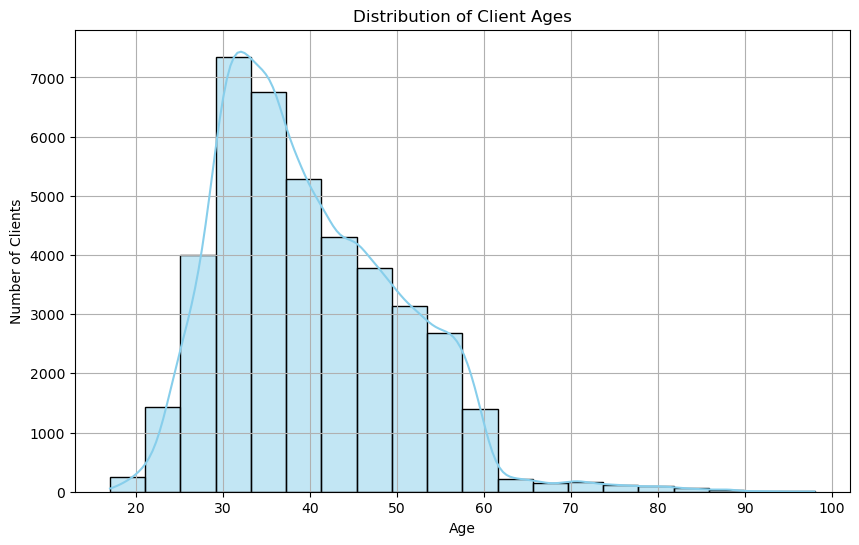

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(client_data['age'] , bins =20 , kde =True , color='skyblue')
plt.title("Distribution of Client Ages")
plt.xlabel("Age")
plt.ylabel("Number of Clients")
plt.grid(True)
plt.show()

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\3958103859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['age_group'] = pd.cut(client_data['age'], bins=bins, labels=labels, right=False)
C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\3958103859.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_dist.index, y=age_group_dist.values, palette='Set2')


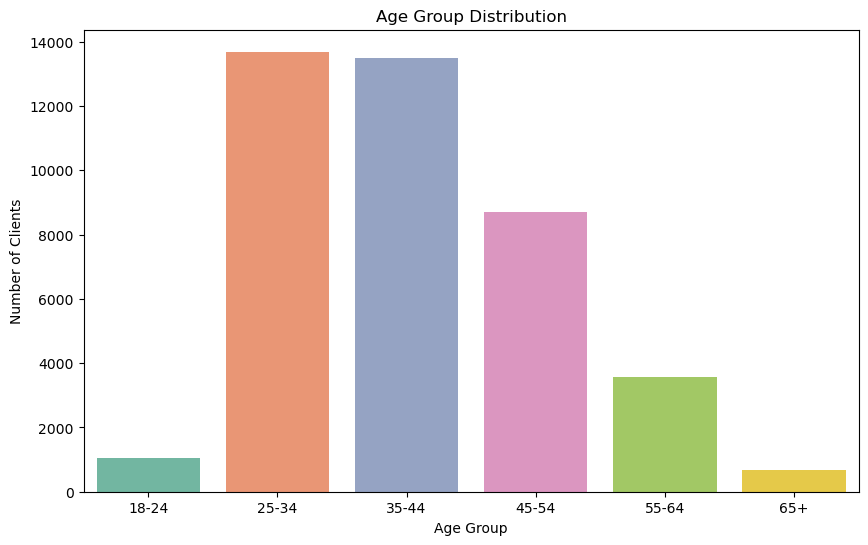

In [18]:
### توزيع الاعمار فى مجموعات عمرية 
client_data['age_group'] = pd.cut(client_data['age'], bins=bins, labels=labels, right=False)

age_group_dist = client_data['age_group'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=age_group_dist.index, y=age_group_dist.values, palette='Set2')
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Number of Clients")
plt.show()

#### توضيح اعمار من لديهم رهن عقارى و الثيؤه على الاستجابه للحمله 

In [19]:
client_data['mortgage'].unique()

<BooleanArray>
[False, True, <NA>]
Length: 3, dtype: boolean

In [20]:
### قياس متوسط الاعمار التى تاخذ قرض رهن عقارى 
avg_age_by_mortgage = client_data.groupby('mortgage')['age'].mean()
avg_age_by_mortgage.index = ['No Mortgage', 'Has Mortgage']     # استبدال القيم الاصليه بالقيم الحاليه للتوضيح فى الطباعه فقط 
avg_age_by_mortgage

No Mortgage     40.044195
Has Mortgage    40.010011
Name: age, dtype: float64

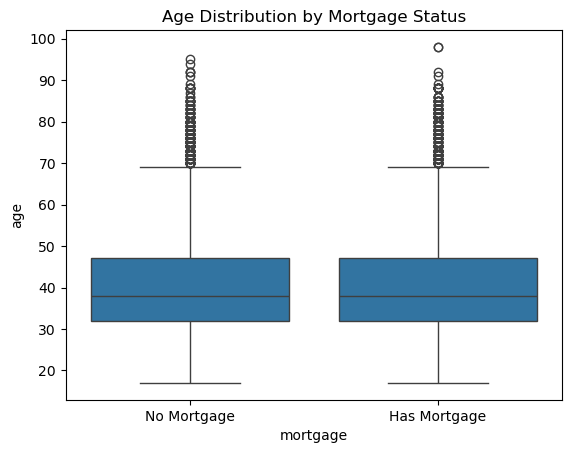

In [21]:
### اذالة القيم الفارغة لنتمكن من تصوير التوزيع 
plot_data = client_data.dropna(subset=['mortgage', 'age'])

sns.boxplot(x='mortgage', y='age', data=plot_data)
plt.xticks([0, 1], ['No Mortgage', 'Has Mortgage'])
plt.title('Age Distribution by Mortgage Status')
plt.show()

In [22]:
client_data['mortgage'].value_counts()


mortgage
True     21576
False    18622
Name: count, dtype: Int64

In [23]:
### توضيح نسبة الاستجابه للحمله من العملاء 
client_data['campaign_outcome'].value_counts(normalize=True) * 100

campaign_outcome
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

#### توضيح العلاقة بين التعليم ونتائج الحملة

In [24]:
client_data['campaign_outcome'].unique()

array(['no', 'yes'], dtype=object)

In [25]:
client_data['campaign_outcome'] = client_data['campaign_outcome'].map({
    'yes': True,
    'no': False
}).astype('bool')


C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\3978275294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_data['campaign_outcome'] = client_data['campaign_outcome'].map({


In [26]:
client_data.groupby('education')['campaign_outcome'].mean().sort_values(ascending=False)

education
illiterate             0.222222
unknown                0.145003
university.degree      0.137245
professional.course    0.113485
high.school            0.108355
basic.4y               0.102490
basic.6y               0.082024
basic.9y               0.078246
Name: campaign_outcome, dtype: float64

In [27]:
client_data['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\2126663695.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_education.values, y=response_by_education.index, palette='viridis')


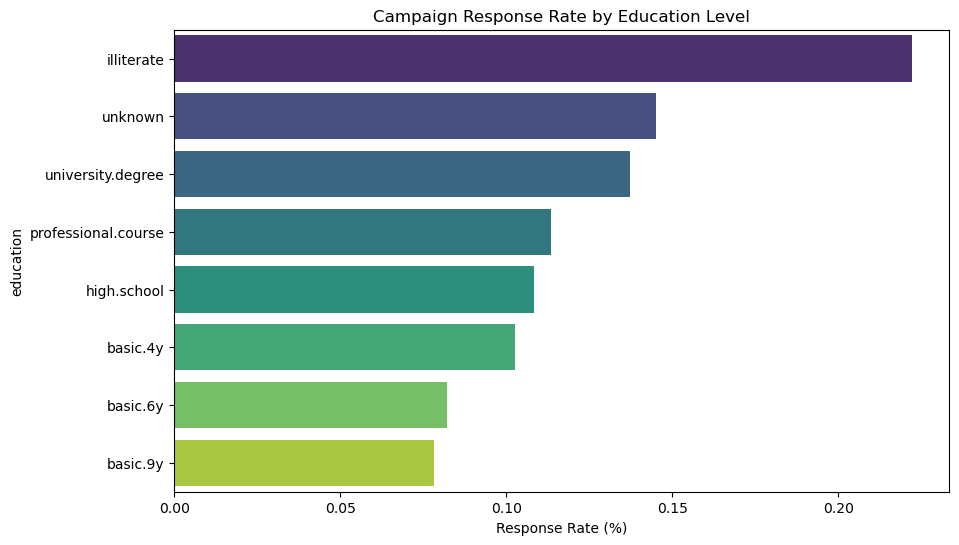

In [28]:
response_by_education = client_data.groupby('education')['campaign_outcome'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=response_by_education.values, y=response_by_education.index, palette='viridis')
plt.xlabel('Response Rate (%)')
plt.title('Campaign Response Rate by Education Level')
plt.show()

#### توضيح تاثير الحاله الاجتماعيه على الاستجابه للقرض

In [29]:
client_data['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [30]:
client_data['marital'].value_counts()

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

In [31]:
response_by_marital = client_data.groupby('marital')['campaign_outcome'].mean().sort_values(ascending=False)
response_by_marital *= 100  
print(response_by_marital)

marital
unknown     15.000000
single      14.004149
divorced    10.320902
married     10.157253
Name: campaign_outcome, dtype: float64


C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\3411412047.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_marital.values, y=response_by_marital.index, palette='mako')


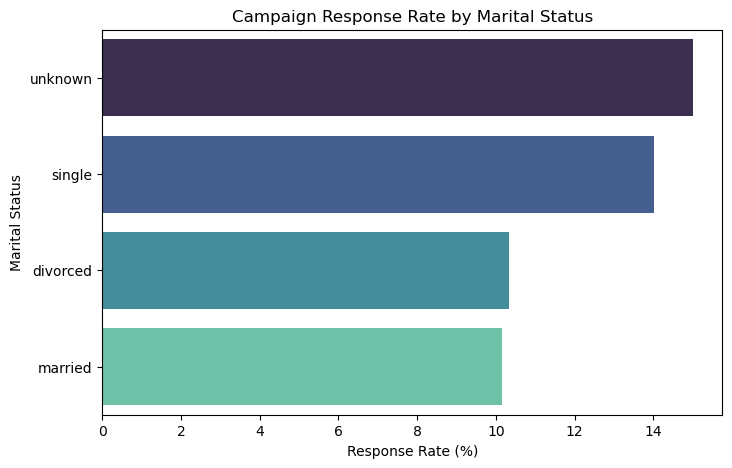

In [32]:
plt.figure(figsize=(8, 5))
sns.barplot(x=response_by_marital.values, y=response_by_marital.index, palette='mako')
plt.xlabel('Response Rate (%)')
plt.ylabel('Marital Status')
plt.title('Campaign Response Rate by Marital Status')
plt.show()

#### توضيح تاثير الوظيفة على الاستجابه للحمله 

In [33]:
client_data['job'].unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [34]:
client_data['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

In [35]:
response_by_job = client_data.groupby('job')['campaign_outcome'].mean().sort_values(ascending=False)
response_by_job *= 100  
print(response_by_job)

job
student          31.428571
retired          25.232558
unemployed       14.201183
admin.           12.972558
management       11.217510
unknown          11.212121
technician       10.826042
self-employed    10.485574
housemaid        10.000000
entrepreneur      8.516484
services          8.138070
blue-collar       6.894316
Name: campaign_outcome, dtype: float64


C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\1448338511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_job.values, y=response_by_job.index, palette='mako')


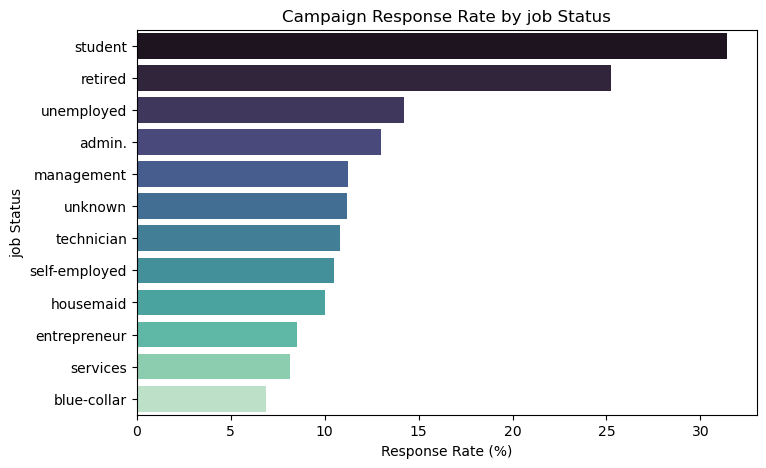

In [36]:
plt.figure(figsize=(8, 5))
sns.barplot(x=response_by_job.values, y=response_by_job.index, palette='mako')
plt.xlabel('Response Rate (%)')
plt.ylabel('job Status')
plt.title('Campaign Response Rate by job Status')
plt.show()

#### تحليل بيانات الحملات الاعلانيه نفسها 

In [37]:
campaign_data['previous_outcome'].unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [38]:
campaign_data['campaign_outcome'] = campaign_data['campaign_outcome'].map({
    'yes': True,
    'no': False
}).astype('boolean')  

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\4147981392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_data['campaign_outcome'] = campaign_data['campaign_outcome'].map({


In [39]:
response_by_prev = campaign_data.groupby('previous_outcome')['campaign_outcome'].mean().sort_values(ascending=False) * 100

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\526740942.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_prev.index, y=response_by_prev.values, palette='crest')


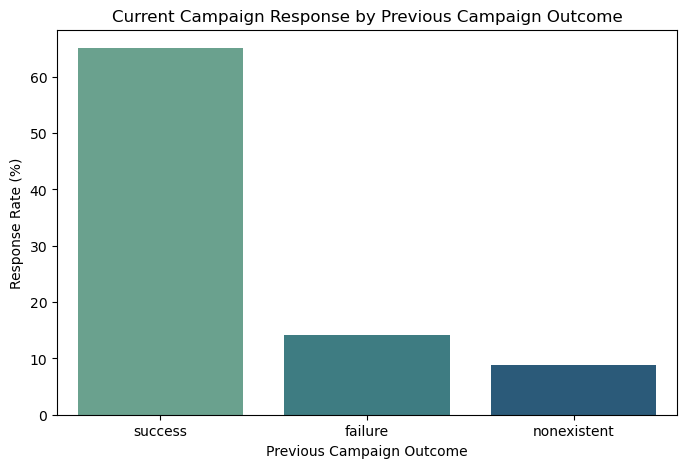

In [40]:
plt.figure(figsize=(8,5))
sns.barplot(x=response_by_prev.index, y=response_by_prev.values, palette='crest')
plt.ylabel('Response Rate (%)')
plt.xlabel('Previous Campaign Outcome')
plt.title('Current Campaign Response by Previous Campaign Outcome')
plt.show()

In [41]:
campaign_data.head()

,client_id,number_contacts,contact_duration,previous_campaign_contacts,previous_outcome,campaign_outcome,last_contact_date
0,0,1,261,0,nonexistent,False,2022-05-13
1,1,1,149,0,nonexistent,False,2022-05-19
2,2,1,226,0,nonexistent,False,2022-05-23
3,3,1,151,0,nonexistent,False,2022-05-27
4,4,1,307,0,nonexistent,False,2022-05-03


#### توضيح علاقة الوقت بلاستجابة للحملة 

In [42]:
campaign_data['month'] = campaign_data['last_contact_date'].dt.month
campaign_data.groupby('month')['campaign_outcome'].mean()

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\4001844153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  campaign_data['month'] = campaign_data['last_contact_date'].dt.month


month
3     0.505495
4     0.204787
5     0.064347
6     0.105115
7     0.090466
8     0.106021
9     0.449123
10    0.438719
11    0.101439
12    0.489011
Name: campaign_outcome, dtype: Float64

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\1421753188.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_response.index, y=monthly_response.values, palette="cubehelix")


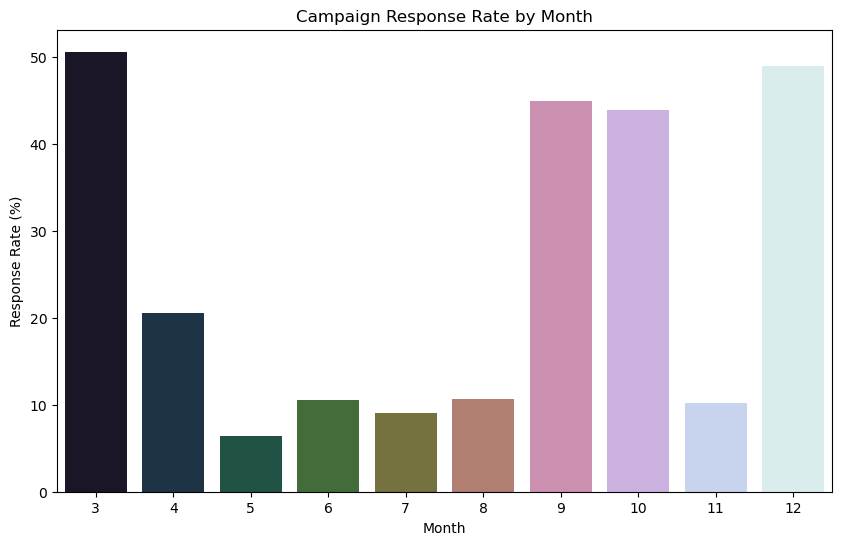

In [43]:
monthly_response = campaign_data.groupby('month')['campaign_outcome'].mean() * 100

plt.figure(figsize=(10,6))
sns.barplot(x=monthly_response.index, y=monthly_response.values, palette="cubehelix")
plt.xlabel("Month")
plt.ylabel("Response Rate (%)")
plt.title("Campaign Response Rate by Month")
plt.show()

#### توضيح علاقة مدة المكالمه بالاستجابة للحملة

<Axes: xlabel='campaign_outcome', ylabel='contact_duration'>

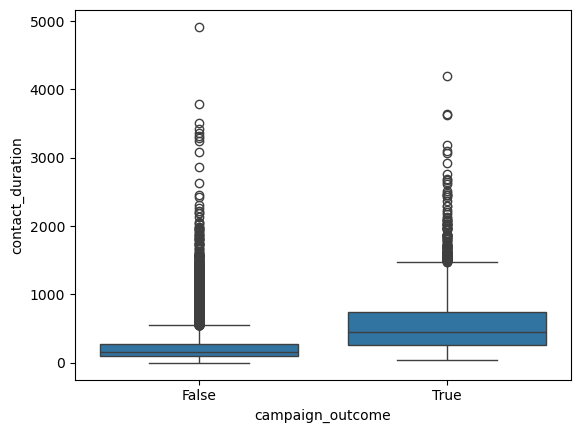

In [44]:
sns.boxplot(data=campaign_data, x='campaign_outcome', y='contact_duration')

#### التعمق اكثر فى التحليل الاصائى مع عدة متغيرات 

In [45]:
# دمج client_data مع campaign_data حسب client_id
merged = client_data.merge(campaign_data[['client_id', 'previous_outcome','campaign_outcome']], on='client_id')

# حساب متوسط العمر حسب نتيجة الحملة السابقة
merged.groupby('previous_outcome')['age'].mean().sort_values()


previous_outcome
failure        39.946143
nonexistent    39.956190
success        42.023307
Name: age, dtype: float64

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\2367635550.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='previous_outcome', y='age', data=merged, palette='Set2')


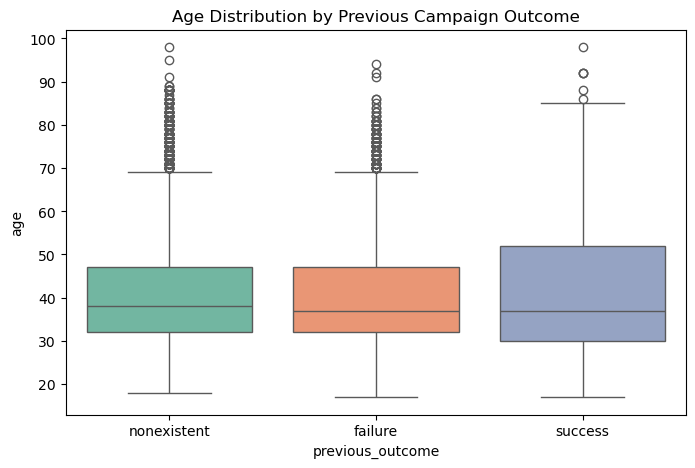

In [46]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='previous_outcome', y='age', data=merged, palette='Set2')
plt.title('Age Distribution by Previous Campaign Outcome')
plt.show()

يظهر أن العملاء الذين نجحت معهم الحملة السابقة يميلون إلى أن يكونوا اصغر قليلا من غيرهم، لكن أيضا هناك تداخل كبير.

In [47]:
# حساب نسبة كل مستوى تعليمي في كل نتيجة سابقة
pd.crosstab(merged['education'], merged['previous_outcome'], normalize='index') * 100

previous_outcome,failure,nonexistent,success
education,,,
basic.4y,8.477011,88.505747,3.017241
basic.6y,9.511344,88.743455,1.745201
basic.9y,10.421836,87.741935,1.836228
high.school,11.760378,85.149764,3.089858
illiterate,5.555556,88.888889,5.555556
professional.course,9.593744,86.915888,3.490368
university.degree,10.207101,85.412558,4.380342
unknown,10.687464,84.402080,4.910456


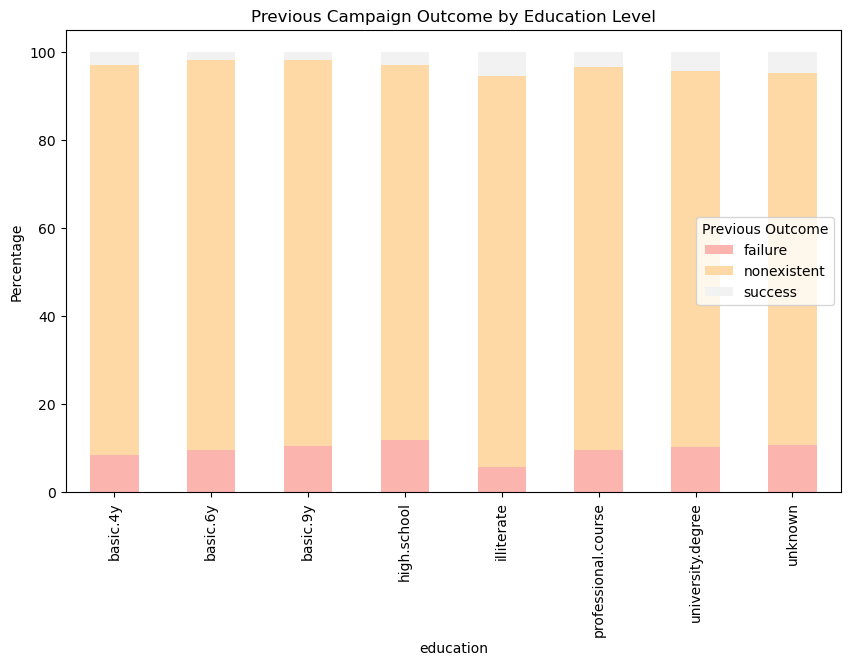

In [48]:
education_prev = pd.crosstab(merged['education'], merged['previous_outcome'], normalize='index') * 100
education_prev.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Pastel1')
plt.ylabel("Percentage")
plt.title("Previous Campaign Outcome by Education Level")
plt.legend(title='Previous Outcome')
plt.show()


In [49]:
response_by_prev = merged.groupby('previous_outcome')['campaign_outcome_y'].mean() * 100
print(response_by_prev)

previous_outcome
failure        14.228598
nonexistent     8.832213
success        65.112891
Name: campaign_outcome_y, dtype: Float64


In [50]:
merged.head()

,client_id,age,job,marital,education,credit_default,mortgage,campaign_outcome_x,age_group,previous_outcome,campaign_outcome_y
0,0,56,housemaid,married,basic.4y,False,False,False,55-64,nonexistent,False
1,1,57,services,married,high.school,<NA>,False,False,55-64,nonexistent,False
2,2,37,services,married,high.school,False,True,False,35-44,nonexistent,False
3,3,40,admin.,married,basic.6y,False,False,False,35-44,nonexistent,False
4,4,56,services,married,high.school,False,False,False,55-64,nonexistent,False


C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\3781427331.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=response_by_prev.index, y=response_by_prev.values, palette='YlGnBu')


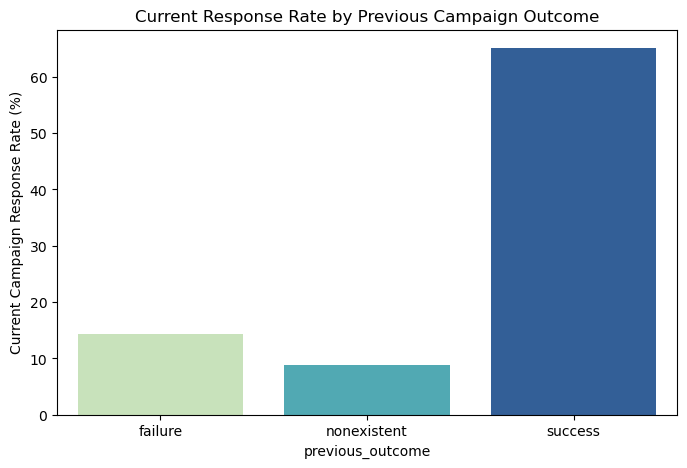

In [51]:
plt.figure(figsize=(8,5))
sns.barplot(x=response_by_prev.index, y=response_by_prev.values, palette='YlGnBu')
plt.ylabel('Current Campaign Response Rate (%)')
plt.title('Current Response Rate by Previous Campaign Outcome')
plt.show()

In [52]:
pd.crosstab(merged['previous_outcome'], merged['campaign_outcome_y'], normalize='index') * 100

campaign_outcome_y,False,True
previous_outcome,,
failure,85.771402,14.228598
nonexistent,91.167787,8.832213
success,34.887109,65.112891


In [53]:
successful_prev = merged[merged['previous_outcome'] == 'success']

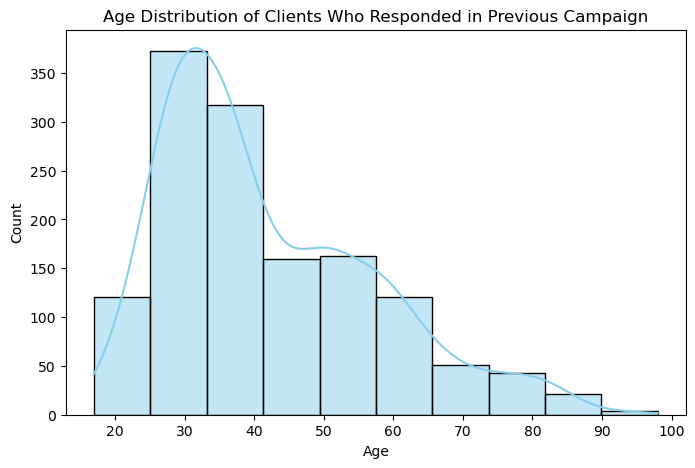

In [54]:
### التوزيع العمرى لمن استجابوا في الحملة السابقة
plt.figure(figsize=(8,5))
sns.histplot(successful_prev['age'], bins=10, kde=True, color='skyblue')
plt.title('Age Distribution of Clients Who Responded in Previous Campaign')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\2521294002.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='campaign_outcome_y', y='age', data=successful_prev, palette='Set2')


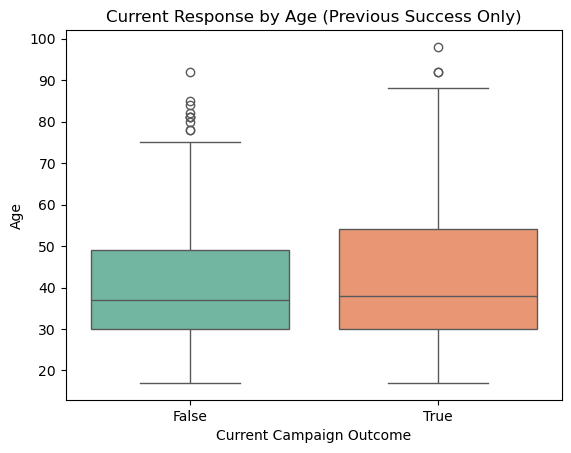

In [55]:
### تأثير العمر على الاستجابة الحالية
sns.boxplot(x='campaign_outcome_y', y='age', data=successful_prev, palette='Set2')
plt.title('Current Response by Age (Previous Success Only)')
plt.xlabel('Current Campaign Outcome')
plt.ylabel('Age')
plt.show()

العملاء الذين استجابوا  يميلون إلى أن يكونوا أكبر سنًا قليلاً من الذين لم يستجيبوا.

هناك تداخل كبير بين المجموعتين، ما يعني أن العمر وحده ليس عاملًا حاسمًا.

In [56]:
success_edu = successful_prev['education'].value_counts(normalize=True) * 100
print(success_edu.sort_values(ascending=False))

education
university.degree      38.820102
high.school            21.412964
professional.course    13.328478
basic.4y                9.176985
basic.9y                8.084487
unknown                 6.190823
basic.6y                2.913328
illiterate              0.072833
Name: proportion, dtype: float64


C:\Users\Omar\AppData\Local\Temp\ipykernel_3368\4294481329.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=success_edu.index, y=success_edu.values, palette='pastel')


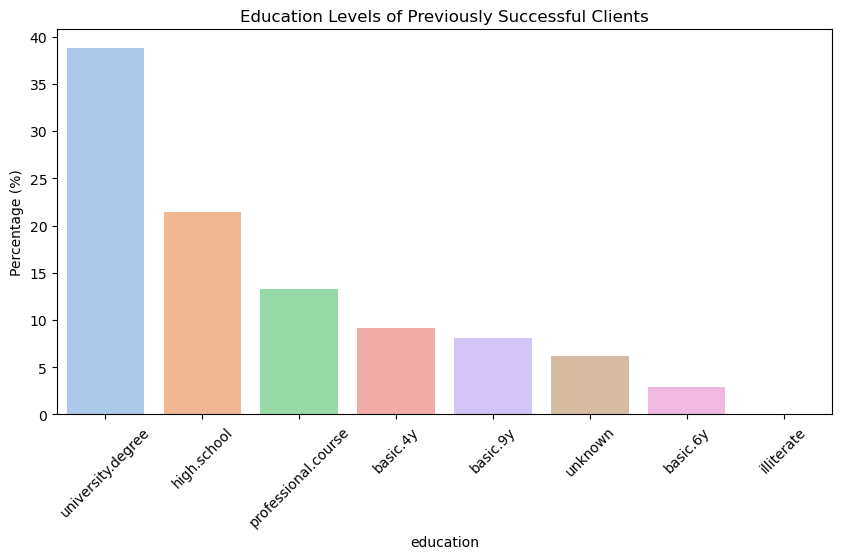

In [57]:
plt.figure(figsize=(10,5))
sns.barplot(x=success_edu.index, y=success_edu.values, palette='pastel')
plt.xticks(rotation=45)
plt.ylabel('Percentage (%)')
plt.title('Education Levels of Previously Successful Clients')
plt.show()

## pridecting analysis 

#### تجهيز البيانات للتحليل التنبؤي

In [60]:
prepData = bankData
prepData.head()

,client_id,age,job,marital,education,credit_default,mortgage,month,day,contact_duration,number_contacts,previous_campaign_contacts,previous_outcome,cons_price_idx,euribor_three_months,campaign_outcome,year,month_num,day_str,last_contact_date
0,0,56,housemaid,married,basic.4y,False,False,may,13,261,1,0,nonexistent,93.994,4.857,no,2022,05,13,2022-05-13
1,1,57,services,married,high.school,<NA>,False,may,19,149,1,0,nonexistent,93.994,4.857,no,2022,05,19,2022-05-19
2,2,37,services,married,high.school,False,True,may,23,226,1,0,nonexistent,93.994,4.857,no,2022,05,23,2022-05-23
3,3,40,admin.,married,basic.6y,False,False,may,27,151,1,0,nonexistent,93.994,4.857,no,2022,05,27,2022-05-27
4,4,56,services,married,high.school,False,False,may,3,307,1,0,nonexistent,93.994,4.857,no,2022,05,03,2022-05-03


In [81]:
# دمج الملفات
procData = client_data.merge(campaign_data, on='client_id').merge(economics_data, on='client_id')
procData.head()

,client_id,age,job,marital,education,credit_default,mortgage,campaign_outcome_x,age_group,number_contacts,contact_duration,previous_campaign_contacts,previous_outcome,campaign_outcome_y,last_contact_date,month,cons_price_idx,euribor_three_months
0,0,56,housemaid,married,basic.4y,False,False,False,55-64,1,261,0,nonexistent,False,2022-05-13,5,93.994,4.857
1,1,57,services,married,high.school,<NA>,False,False,55-64,1,149,0,nonexistent,False,2022-05-19,5,93.994,4.857
2,2,37,services,married,high.school,False,True,False,35-44,1,226,0,nonexistent,False,2022-05-23,5,93.994,4.857
3,3,40,admin.,married,basic.6y,False,False,False,35-44,1,151,0,nonexistent,False,2022-05-27,5,93.994,4.857
4,4,56,services,married,high.school,False,False,False,55-64,1,307,0,nonexistent,False,2022-05-03,5,93.994,4.857


### Features

age

job

marital

education

credit_default

mortgage

previous_outcome

number_contacts

contact_duration

previous_campaign_contacts

cons_price_idx

euribor_three_months

In [82]:
procData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   41188 non-null  int64         
 1   age                         41188 non-null  int64         
 2   job                         41188 non-null  object        
 3   marital                     41188 non-null  object        
 4   education                   41188 non-null  object        
 5   credit_default              32591 non-null  boolean       
 6   mortgage                    40198 non-null  boolean       
 7   campaign_outcome_x          41188 non-null  bool          
 8   age_group                   41183 non-null  category      
 9   number_contacts             41188 non-null  int64         
 10  contact_duration            41188 non-null  int64         
 11  previous_campaign_contacts  41188 non-null  int64     

In [83]:
procData['target'] = procData['campaign_outcome_y']

In [84]:
procData = procData.drop(columns=['client_id', 'campaign_outcome_x', 'campaign_outcome_y', 'age_group', 'last_contact_date', 'month'])

In [85]:
for col in ['credit_default', 'mortgage']:
    most_common = procData[col].mode()[0]
    procData[col] = procData[col].fillna(most_common)

In [86]:
X = procData.drop(columns='target')
y = procData['target']

In [87]:
categorical_cols = ['job', 'marital', 'education', 'previous_outcome']
numeric_cols = ['age', 'number_contacts', 'contact_duration', 'previous_campaign_contacts', 'cons_price_idx', 'euribor_three_months']
boolean_cols = ['credit_default', 'mortgage']

In [88]:
for col in boolean_cols:
    X[col] = X[col].astype(int)  # يحول True/False إلى 1/0

In [89]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'  # يمرر الأعمدة الأخرى كما هي
)

X_processed = preprocessor.fit_transform(X)

In [90]:
from sklearn.model_selection import train_test_split

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ],
    remainder='passthrough'  # يمرر الأعمدة الأخرى كما هي
)

X_processed = preprocessor.fit_transform(X)

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [93]:
procData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         41188 non-null  int64  
 1   job                         41188 non-null  object 
 2   marital                     41188 non-null  object 
 3   education                   41188 non-null  object 
 4   credit_default              41188 non-null  boolean
 5   mortgage                    41188 non-null  boolean
 6   number_contacts             41188 non-null  int64  
 7   contact_duration            41188 non-null  int64  
 8   previous_campaign_contacts  41188 non-null  int64  
 9   previous_outcome            41188 non-null  object 
 10  cons_price_idx              41188 non-null  float64
 11  euribor_three_months        41188 non-null  float64
 12  target                      41188 non-null  boolean
dtypes: boolean(3), float64(2), int6

In [96]:
pd.DataFrame(X_train).isnull().sum().sum()

7668

In [97]:
X_train_df = pd.DataFrame(X_train)

X_train_df.isnull().sum().sum()  # عدد القيم الفارغة


7668

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# الأعمدة حسب النوع
categorical_cols = ['job', 'marital', 'education', 'previous_outcome']
numeric_cols = ['age', 'number_contacts', 'contact_duration', 'previous_campaign_contacts', 'cons_price_idx', 'euribor_three_months']
boolean_cols = ['credit_default', 'mortgage']

# بايبلاين الأعمدة الفئوية
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# بايبلاين الأعمدة الرقمية + البوليانية
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

# دمج الكل
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_pipe, categorical_cols),
    ('num', numeric_pipe, numeric_cols + boolean_cols)
])


In [101]:
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [102]:
pd.DataFrame(X_train).isnull().sum().sum()


0

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# إنشاء النموذج
model = RandomForestClassifier(random_state=42)

# تدريب النموذج
model.fit(X_train, y_train)

# توقع القيم على مجموعة الاختبار
y_pred = model.predict(X_test)


In [104]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[7054  249]
 [ 484  451]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      7303
         1.0       0.64      0.48      0.55       935

    accuracy                           0.91      8238
   macro avg       0.79      0.72      0.75      8238
weighted avg       0.90      0.91      0.91      8238



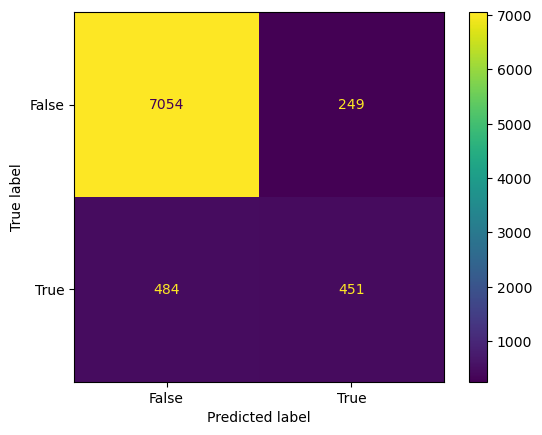

In [182]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

True Positives (TP) = 451: عدد العملاء الذين استجابوا فعلاً للحملة وتنبأ النموذج بذلك.

True Negatives (TN) = 7054: عدد العملاء الذين لم يستجيبوا فعلاً ولم يتنبأ النموذج باستجابتهم.

False Positives (FP) = 249: النموذج تنبأ باستجابة، لكن العميل لم يستجب.

False Negatives (FN) = 484: العميل استجاب فعلاً، لكن النموذج لم يتنبأ بذلك.

